In [40]:
#Load libraries to memory
import re
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import LinearRegression,Lasso, Ridge, RidgeCV
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,r2_score

## Data Cleaning & Preprocessing (1–15)

In [41]:
# 1. Load the dataset into a Pandas DataFrame and display the first 5 rows.
# Data URL : https://www.kaggle.com/datasets/sukhmandeepsinghbrar/car-price-prediction-dataset
carPriceDataset = pd.read_csv("../data/raw/cardekho.csv")
carPriceDataset.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78,5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.2,5.0


In [42]:
"""
Columns name definitions:-
1. name : The brand and model of the car (e.g., Maruti Swift Dzire, Hyundai i20).
2. year : The year the car was manufactured.
3. selling_price : The price at which the car is being sold.
4. km_driven : Total distance the car has been driven, in kilometers.
5. fuel : The type of fuel the car uses (e.g., Petrol, Diesel, CNG, LPG, Electric).
6. seller_type: Who is selling the car (e.g., Individual, Dealer).
7. transmission : Type of gearbox (e.g., Manual or Automatic).
8. owner : Indicates how many previous owners the car has had (e.g., First Owner, Second Owner).
9. mileage(km/ltr/kg)/mileage : The fuel efficiency of the car:
10. engine : The engine displacement (e.g., 1197 CC, 1498 CC).
11. max_power : The maximum power output of the engine (e.g., 83 bhp, 100 PS).
12. seats : Number of seats in the car (e.g., 5, 7, 8), higher seat counts means more space for the gossip club &
Can also be flattened to accommodate more than 380 cabbages.
"""
print(carPriceDataset.columns)

Index(['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage(km/ltr/kg)', 'engine', 'max_power',
       'seats'],
      dtype='object')


In [43]:
# 2. Check for missing values in the dataset.
# Show both the number of missing values per column and the percentage.
missing_analysis = (
    carPriceDataset
    .isna()
    .sum()
    .to_frame(name='missingCount')
    .assign(totalRows=len(carPriceDataset))
    .assign(percentageMissing=lambda df_: (df_.missingCount / df_.totalRows * 100).round(2))
)

print(missing_analysis)

                    missingCount  totalRows  percentageMissing
name                           0       8128               0.00
year                           0       8128               0.00
selling_price                  0       8128               0.00
km_driven                      0       8128               0.00
fuel                           0       8128               0.00
seller_type                    0       8128               0.00
transmission                   0       8128               0.00
owner                          0       8128               0.00
mileage(km/ltr/kg)           221       8128               2.72
engine                       221       8128               2.72
max_power                    215       8128               2.65
seats                        221       8128               2.72


In [44]:
""""
#3. Drop any rows where the target variable (selling price) is missing.
    Explain why we can’t train a model with missing target values:-
  -  Without complete targets in Supervised learning, the model cannot learn the relationship between features and outcomes.
  - Evaluation also becomes impossible without ground truth for validation. Unlike features (which can be imputed), targets are irreplaceable.
  - Target data integrity is non-negotiable for successful model training.
Ans: Since there is no missing target values in the dataset, then we retain all values as is.

#4. Fill missing values in the “mileage” column with the column’s mean. Explain why filling missing values can sometimes be better than dropping rows.
Ans: Filling preserves data volume and statistical power. Dropping rows can introduce bias and reduce dataset size, weakening analysis
    
#5. Remove duplicate rows from the dataset. Explain how duplicate rows can affect model training.
Ans: Duplicate rows can skew model training by overemphasizing certain patterns, leading to overfitting,
     inflated performance metrics, and biased estimates that fail to generalize well to new data

#6. Convert the “year” column into the car’s age.
 Example: If the car’s year is 2015 and the current year is 2025, the age is 10 years.
 
#8. Replace inconsistent values in the “transmission” column.
   For example, replace “manual” and “Manual” with “Manual” (consistent casing).

#10. Remove cars that are priced below 10,000 or above 5,000,000 (possible outliers).
 Explain why setting realistic price limits can help improve model performance.
 Ans:  
 -Eliminates extreme outliers (like 10M car) that skew training data and distort the model's understanding of typical pricing patterns
- Creates more representative means, medians, and distributions that better reflect actual market conditions for typical cars.
 - Ensures the model performs well on the 95% of cars that fall within normal price ranges, where most sales and revenue occur.

#11. Standardize the column names so they are all lowercase and contain underscores instead of spaces.

#12. Check if any numerical columns are stored as strings and convert them to numbers.

#13. Create a new column for “price per kilometer” by dividing the selling price by the mileage.

#14. 14. Ensure the dataset index is properly reset after cleaning.
 """


def clean_numeric_column(df, col, fill_method="mean", cast_int=True):
    """Custom cleaning funct, text column --> numeric with safe handling of edge texts"""
    series = df[col].astype(str)
    #Extract numeric part
    series = series.str.extract(r'(\d+\.?\d*)')[0]
    series = pd.to_numeric(series, errors="coerce")
    if fill_method == "mean":
        series = series.fillna(series.mean())
    if cast_int:
        series = series.astype(int)
    return series

class MissingDict(dict):
    __missing__ = lambda self, key: key

#mapping values
map_values = {"manual": "Manual"}
    
mapping = MissingDict(**map_values)

def tweakCarPriceDf(df):
    return (df
        .dropna(subset = ['selling_price'])
        .drop_duplicates()
        .rename(columns = lambda c : c.split('(')[0])
        
        .assign(km_driven=lambda df_: clean_numeric_column(df_, "km_driven"),
            engine=lambda df_: clean_numeric_column(df_, "engine"),
            mileage=lambda df_: clean_numeric_column(df_, "mileage"),
            max_power=lambda df_: clean_numeric_column(df_, "max_power"),
            seats=lambda df_: clean_numeric_column(df_, "seats"))
        

        .assign(carAge = lambda df_ : (2025 - df_.year).astype(int),
                transmission =lambda df: df['transmission'].map(mapping))
        .query('selling_price < 5000000 & selling_price >10000')
        
        #.info()
        #Columns conversion to approiate dtypes
         .assign(price_per_kilometer = lambda df_ : df_.selling_price /df_.km_driven
                )
         .reset_index(drop =True)
        
        )

In [45]:
cleanedCarPriceDf = tweakCarPriceDf(carPriceDataset)
cleanedCarPriceDf.to_csv("../data/processed/cardekho.csv")
cleanedCarPriceDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6906 entries, 0 to 6905
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 6906 non-null   object 
 1   year                 6906 non-null   int64  
 2   selling_price        6906 non-null   int64  
 3   km_driven            6906 non-null   int32  
 4   fuel                 6906 non-null   object 
 5   seller_type          6906 non-null   object 
 6   transmission         6906 non-null   object 
 7   owner                6906 non-null   object 
 8   mileage              6906 non-null   int32  
 9   engine               6906 non-null   int32  
 10  max_power            6906 non-null   int32  
 11  seats                6906 non-null   int32  
 12  carAge               6906 non-null   int32  
 13  price_per_kilometer  6906 non-null   float64
dtypes: float64(1), int32(6), int64(2), object(5)
memory usage: 593.6+ KB


In [46]:
#7. Check the unique values in the “fuel type” column.
# Explain why knowing all possible values in a categorical column is important before encoding.
"""Before encoding, you must know all categories to ensure consistency between training and new data. 
   Missing categories in new data can cause errors or incorrect predictions if the encoder hasn't seen them before."""
categorical_analysis =(carPriceDataset.dropna(subset = ['selling_price'])
.drop_duplicates()
.fuel.value_counts(dropna = False) 
)
categorical_analysis

fuel
Diesel    3755
Petrol    3077
CNG         56
LPG         38
Name: count, dtype: int64

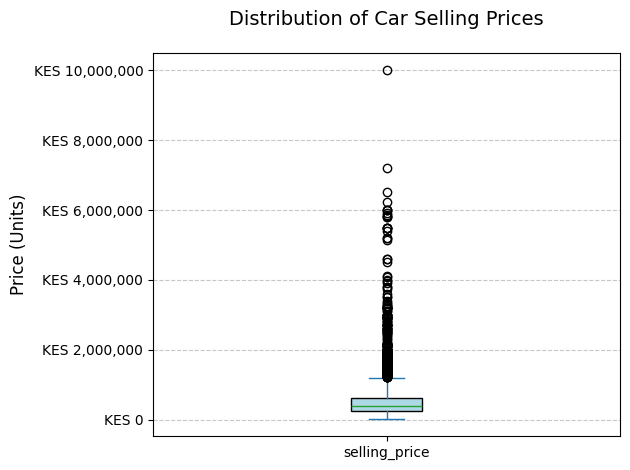

In [47]:
#9. Check if there are any outliers in the “selling price” column using a boxplot.
# Explain why outliers can affect model accuracy.
"""
-Ans-
Outliers skew statistics models rely on. The KES 10M car pulls the average far above typical prices (KES 0-1M range),
forcing models to waste capacity fitting rare cases instead of common ones. This causes poor predictions on normal cars where most business value lies. 

Solution: is to remove or transform outliers first
"""
def format_currency(x, pos):
    """Formats numbers as currency with commas and a symbol."""
    return f'KES {x:,.0f}'
    
ax = (carPriceDataset.dropna(subset = ['selling_price'])
.drop_duplicates()
.loc[:,['selling_price']]
#.query('selling_price < 5000000 & selling_price >10000')
.plot.box(patch_artist=True,boxprops=dict(facecolor='lightblue')) 
)
ax.set_title('Distribution of Car Selling Prices', fontsize=14, pad=20)
ax.set_ylabel('Price (Units)', fontsize=12) 
ax.set_xlabel('') 
ax.ticklabel_format(style='plain', axis='y') 
ax.yaxis.set_major_formatter(FuncFormatter(format_currency))
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Exploratory Data Analysis (EDA) (16–30)

In [48]:
#16. Find the average selling price of cars in the dataset.
cleanedCarPriceDf = tweakCarPriceDf(carPriceDataset)
sellingPriceAnalysis = (cleanedCarPriceDf
.selling_price
.mean()
)
print(f"Average selling price of cars : {sellingPriceAnalysis}")

Average selling price of cars : 501378.18114682887


In [49]:
#17. Find the most common fuel type in the dataset.
commonFuelType = (cleanedCarPriceDf
.fuel
.value_counts(dropna =False)
.iloc[:1]
)
commonFuelType

fuel
Diesel    3741
Name: count, dtype: int64

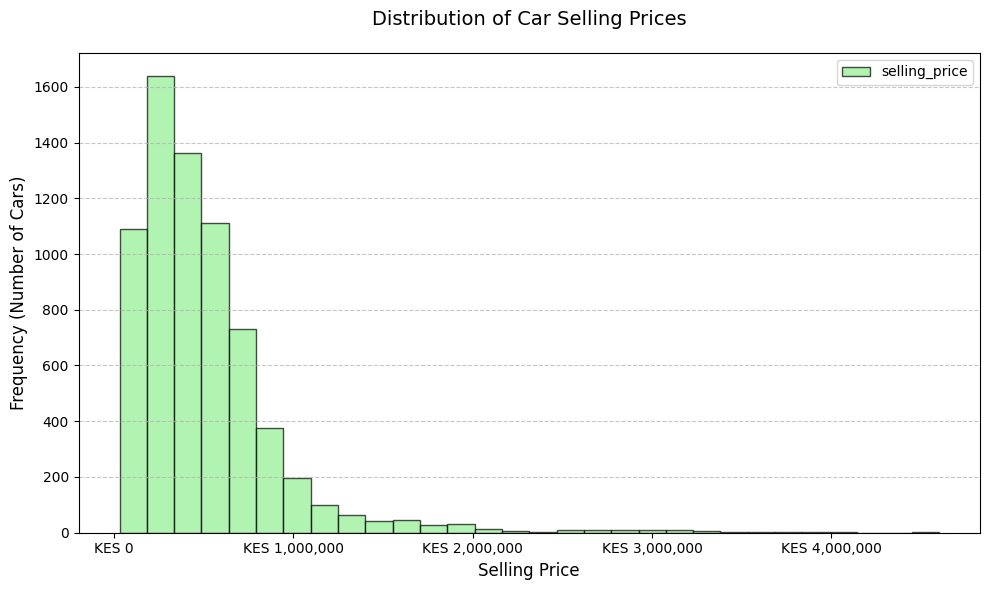

In [50]:
#18. Plot a histogram of the selling prices.
ax= (cleanedCarPriceDf
.loc[:,['selling_price']]
    .plot.hist(bins=30,
               edgecolor='black',   # Black edges on bars
               alpha=0.7,  # Slight transparency
               color='lightgreen',                   
               figsize=(10, 6))                      
)
# Formatting the histogram
ax.set_title('Distribution of Car Selling Prices', fontsize=14, pad=20)
ax.set_ylabel('Frequency (Number of Cars)', fontsize=12) 
ax.set_xlabel('Selling Price', fontsize=12)
ax.ticklabel_format(style='plain', axis='x')
ax.xaxis.set_major_formatter(FuncFormatter(format_currency))
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

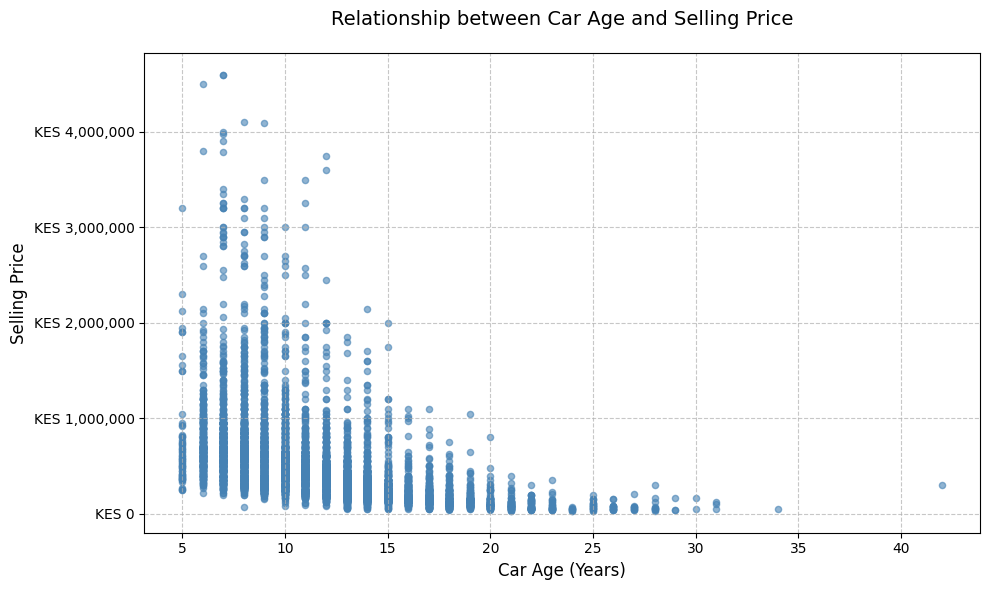

In [51]:
#19. Plot the relationship between car age and selling price using a scatter plot.
ax= (cleanedCarPriceDf
.loc[:,['selling_price','carAge']]
.plot.scatter(x='carAge', 
                    y='selling_price',
                    alpha=0.6, #Transparency for overlapping points
                    c='steelblue', # Point color
                    figsize=(10, 6))
)
# Formatting the scatter plot
ax.set_title('Relationship between Car Age and Selling Price', fontsize=14, pad=20)
ax.set_ylabel('Selling Price', fontsize=12)
ax.set_xlabel('Car Age (Years)', fontsize=12)
ax.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(FuncFormatter(format_currency))
ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [52]:
#20. Group cars by fuel type and find the average selling price for each group.
(cleanedCarPriceDf
.groupby(['fuel'])
.agg(averageSellingPrice= ('selling_price','mean'))
#.round(2) 
.sort_values('averageSellingPrice', ascending=False)
.reset_index(drop= False)
.style.format({"averageSellingPrice": "{:,.2f}"})
)

,fuel,averageSellingPrice
0,Diesel,"620,448.48"
1,Petrol,"363,717.34"
2,CNG,"300,499.95"
3,LPG,"200,421.05"


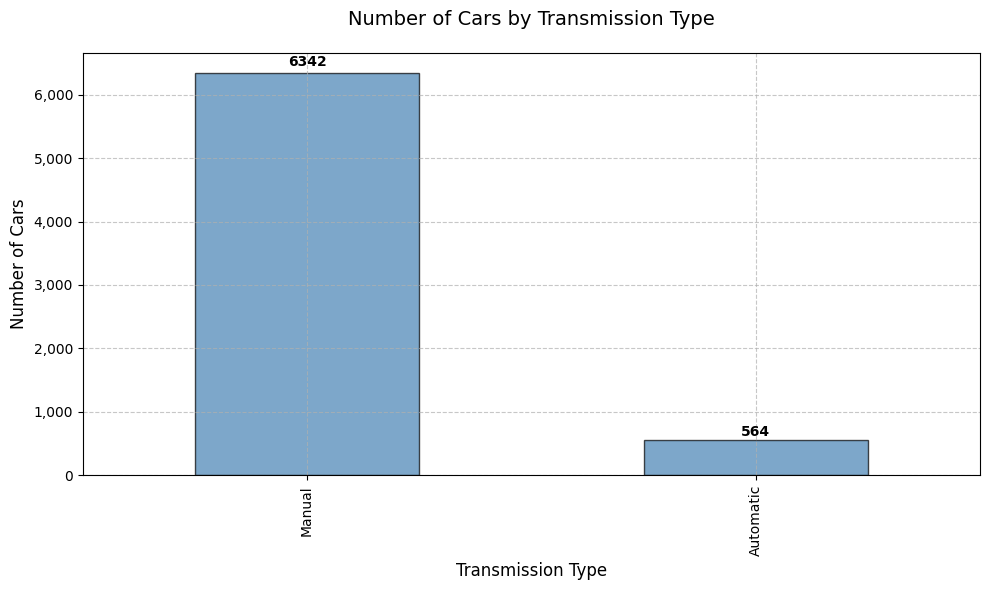

In [53]:
#21. Plot a bar chart showing the number of cars per transmission type.
ax = (cleanedCarPriceDf
    .transmission
    .value_counts(dropna= False)
    .plot(kind='bar',
          color='steelblue', 
          alpha=0.7,
          edgecolor='black',
          figsize=(10, 6))
     )
# Formatting the bar chart
ax.set_title('Number of Cars by Transmission Type', fontsize=14, pad=20)
ax.set_ylabel('Number of Cars', fontsize=12)
ax.set_xlabel('Transmission Type', fontsize=12)
ax.ticklabel_format(style='plain', axis='y')

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:,.0f}'))
ax.grid(True, linestyle='--', alpha=0.7) 

# Add value labels on top of each bar
for i, v in enumerate(cleanedCarPriceDf['transmission'].value_counts()):
    ax.text(i, v + 0.01 * v, str(v), ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

In [54]:
#22 Find the car with the highest mileage in the dataset.
highest_mileage_car = (cleanedCarPriceDf
    .loc[:,['km_driven']]
    .idxmax()
)
print(f"Car with the Highest Mileage:{highest_mileage_car}")

Car with the Highest Mileage:km_driven    3152
dtype: int64


In [55]:
#23 Calculate the correlation between mileage and selling price.
"""
A correlation of 0 means that as one variable increases, the other doesn’t
respond. A negative correlation indicates that one variable goes down as the other goes up.

This Spearman correlation matrix shows a moderate negative correlation of -0.284505 between selling price and kilometers driven.
- As kilometers driven increases, selling price tends to decrease
- The relationship is monotonic (consistently in one direction) but not perfectly linear.
Interpretation:
- Cars with higher mileage generally sell for less money, which aligns with expected depreciation patterns.
However, the moderate strength suggests that mileage alone doesn't fully determine price
other factors like car age, brand, condition, and model likely play significant roles"""
(cleanedCarPriceDf
.loc[:,['selling_price','km_driven']]
.corr(method = 'spearman')
.style
.background_gradient(cmap='RdBu', vmax=1, vmin=-1)
)

,selling_price,km_driven
selling_price,1.000000,-0.284505
km_driven,-0.284505,1.000000


In [56]:
#24. Plot a heatmap showing the correlations between all numeric columns.
"""
Strongest Relationships:
- price_per_kilometer vs selling_price (0.797): Strong positive correlation - this derived metric is highly predictive
- km_driven vs price_per_kilometer (-0.774): Strong negative relationship - higher mileage drastically reduces price efficiency
- carAge vs price_per_kilometer (-0.809): Strongest negative correlation - older cars have much lower price per km value
"""
(cleanedCarPriceDf
.loc[:,['selling_price','km_driven','mileage','engine','max_power','seats','carAge','price_per_kilometer']]
.corr(method = 'spearman')
.style
.background_gradient(cmap='RdBu', vmax=1, vmin=-1)
.set_sticky(axis='index')
)

,selling_price,km_driven,mileage,engine,max_power,seats,carAge,price_per_kilometer
selling_price,1.000000,-0.284505,0.035866,0.450752,0.605584,0.331156,-0.703136,0.797042
km_driven,-0.284505,1.000000,-0.207804,0.319241,0.068044,0.195750,0.566463,-0.774423
mileage,0.035866,-0.207804,1.000000,-0.426645,-0.293616,-0.444220,-0.357790,0.163673
engine,0.450752,0.319241,-0.426645,1.000000,0.729413,0.537331,0.057378,0.080657
max_power,0.605584,0.068044,-0.293616,0.729413,1.000000,0.323125,-0.150107,0.329234
seats,0.331156,0.195750,-0.444220,0.537331,0.323125,1.000000,-0.053832,0.101165
carAge,-0.703136,0.566463,-0.357790,0.057378,-0.150107,-0.053832,1.000000,-0.808795
price_per_kilometer,0.797042,-0.774423,0.163673,0.080657,0.329234,0.101165,-0.808795,1.000000


In [57]:
# 25. Check if manual cars are generally cheaper or more expensive than automatic cars...
price_comparison = (cleanedCarPriceDf
                    .groupby('transmission')  
                    .agg(average_price=('selling_price', 'mean'),
                        median_price=('selling_price', 'median'),
                        car_count=('selling_price', 'count')
                    )
                    .round(2)
                    .sort_values('average_price', ascending=False)
                   )
print(price_comparison)
#print("Price Comparison: Manual vs Automatic Cars")
#print(price_comparison)
#print("\n")
# Calculate the price difference
manual_avg = price_comparison.loc['Manual', 'average_price']
auto_avg = price_comparison.loc['Automatic', 'average_price']
price_difference = auto_avg - manual_avg
diff_percentage = (price_difference / manual_avg) * 100

print(f"Automatic cars are {price_difference:,.0f} KES ({diff_percentage:.1f}%) more expensive than manual cars on average.")

              average_price  median_price  car_count
transmission                                        
Automatic        1143214.51      800000.0        564
Manual            444299.07      385000.0       6342
Automatic cars are 698,915 KES (157.3%) more expensive than manual cars on average.


In [58]:
#26. Find the average selling price for each year of manufacture.
yearlyAvgSellingPrice = (cleanedCarPriceDf
                    .groupby('year')  
                    .agg(averageSellingPrice=('selling_price', 'mean'))
                    .round(2)
                    .sort_values('averageSellingPrice', ascending=False)
                    #.style.format(thousands=",")
                    .style.format({"averageSellingPrice": "{:,.2f}"})
                   )
yearlyAvgSellingPrice

,averageSellingPrice
year,
2018,"825,749.55"
2019,"795,583.29"
2020,"786,548.34"
2017,"708,006.17"
2016,"653,180.34"
2015,"589,177.63"
2014,"511,858.80"
2013,"451,501.72"
2012,"351,387.38"


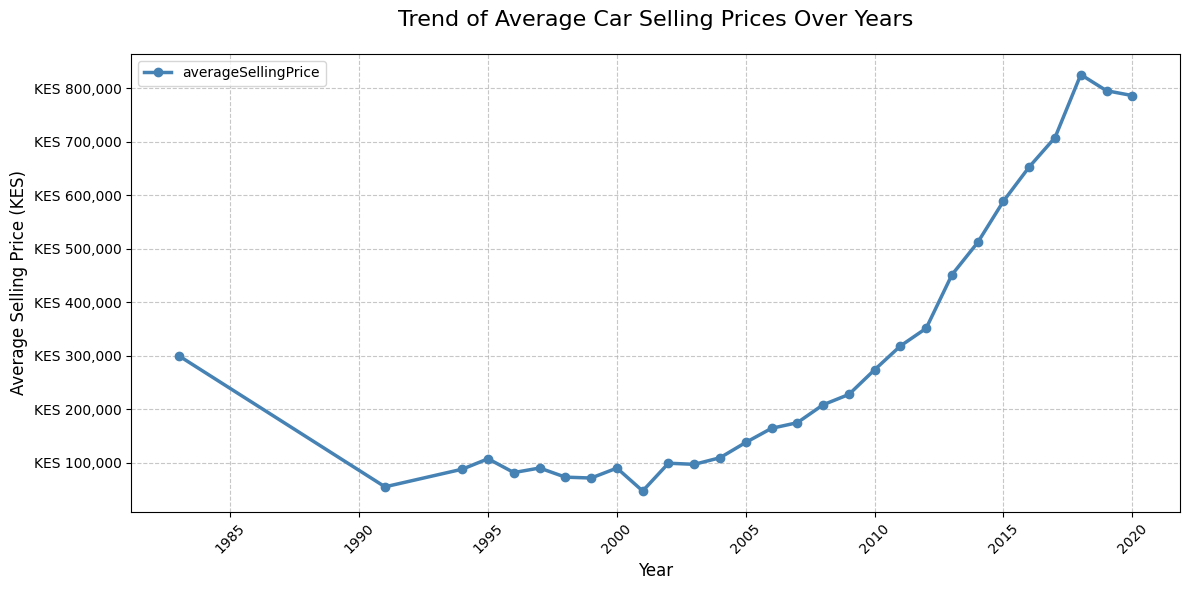

In [59]:
#27. Plot a line chart showing the trend of selling prices over the years.
ax = (cleanedCarPriceDf
    .groupby('year')  
    .agg(averageSellingPrice=('selling_price', 'mean'))
    .round(2)
    .sort_index()
    .plot(kind='line',
          marker='o',
          linestyle='-',
          color='steelblue',
          figsize=(12, 6),
          linewidth=2.5)
     )
# Formatting the line chart
ax.set_title('Trend of Average Car Selling Prices Over Years', fontsize=16, pad=20)
ax.set_ylabel('Average Selling Price (KES)', fontsize=12)
ax.set_xlabel('Year', fontsize=12)
ax.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(FuncFormatter(format_currency))
ax.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)


plt.tight_layout()
plt.show()

In [60]:
#28. Find the most expensive car for each fuel type.
mostExpensiveByFuel = (cleanedCarPriceDf
    .sort_values('selling_price', ascending=False) 
    .groupby('fuel')
    .first()
    .reset_index()
    .loc[:, ['fuel', 'name', 'selling_price', 'year', 'transmission']] 
    .style.format({"selling_price": lambda x: f"KES {x:,.0f}"})
                      )
mostExpensiveByFuel

,fuel,name,selling_price,year,transmission
0,CNG,Maruti Ertiga VXI CNG Limited Edition,"KES 545,000",2014,Manual
1,Diesel,Mercedes-Benz GL-Class 220d 4MATIC Sport,"KES 4,600,000",2018,Automatic
2,LPG,Hyundai i10 Sportz 1.1L LPG,"KES 375,000",2015,Manual
3,Petrol,Jeep Wrangler 2016-2019 3.6 4X4,"KES 4,100,000",2017,Automatic


In [61]:
#29. Find out which brand appears most frequently in the dataset.
# Maruti appears most frequently with multiple models-  count 2,165
(cleanedCarPriceDf
.assign(brand = lambda df_ : df_.name.str.split().str[0])
.brand.value_counts(dropna =False)
.iloc[:1]
)

brand
Maruti    2165
Name: count, dtype: int64

In [62]:
#30. Check the top 5 most common combinations of fuel type and transmission.
topCombinations = (cleanedCarPriceDf
    .groupby(['fuel', 'transmission'])
    .size()  #count occurence of each combination
    .sort_values(ascending=False)
    .head(5) 
    .reset_index(name='count')
     .style.format({"count": lambda x: f"{x:,.0f}"})
                  )
topCombinations

,fuel,transmission,count
0,Diesel,Manual,"3,457"
1,Petrol,Manual,"2,791"
2,Diesel,Automatic,284
3,Petrol,Automatic,280
4,CNG,Manual,56


## Machine Learning (31–40)

In [63]:
#31. What are the main assumptions of Linear Regression, and how can you check them using this dataset?
# Explain the assumptions (Linearity, Homoscedasticity, Normality of residuals, No multicollinearity, Independence of errors). 
#Then, write code to verify at least three of these assumptions using visualizations or statistics.
"""
Main Assumptions of Linear Regression
1. Linearity - Relationship between independent variables and the dependent variable is linear.
2. Independence - Observations are independent of each other. No correlation should exist between residuals of different data points.
3. Homoscedasticity (Constant Variance) - Residuals have constant variance across all levels of predicted values. The "spread" of errors should remain uniform.
4. Normality of Residuals - Residuals (errors) are normally distributed around zero.
5. No Multicollinearity -  Independent variables should not be highly correlated with each other. 
6. No Autocorrelation - Residuals should not be correlated with each other, especially important in time series data.
"""

# Prepare the data by selecting features and target...
model_data = (cleanedCarPriceDf
    .loc[:,['selling_price', 'carAge', 'km_driven', 'engine', 'max_power']]
             )

X = model_data[['carAge']]  # pick one feature for simplicity
y = model_data['selling_price']

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Calculate predictions and residuals
y_pred = model.predict(X)
residuals = y - y_pred

# Create a DataFrame for assumption checking
assumption_df = pd.DataFrame({'Actual': y, 'Predicted': y_pred, 'Residuals': residuals, 'CarAge': X['carAge']})
assumption_df

,Actual,Predicted,Residuals,CarAge
0,450000,531466.640519,-81466.640519,11
1,370000,531466.640519,-161466.640519,11
2,158000,126514.824835,31485.175165,19
3,225000,328990.732677,-103990.732677,15
4,130000,177133.801795,-47133.801795,18
...,...,...,...,...
6901,260000,480847.663558,-220847.663558,12
6902,475000,531466.640519,-56466.640519,11
6903,320000,480847.663558,-160847.663558,12
6904,135000,177133.801795,-42133.801795,18


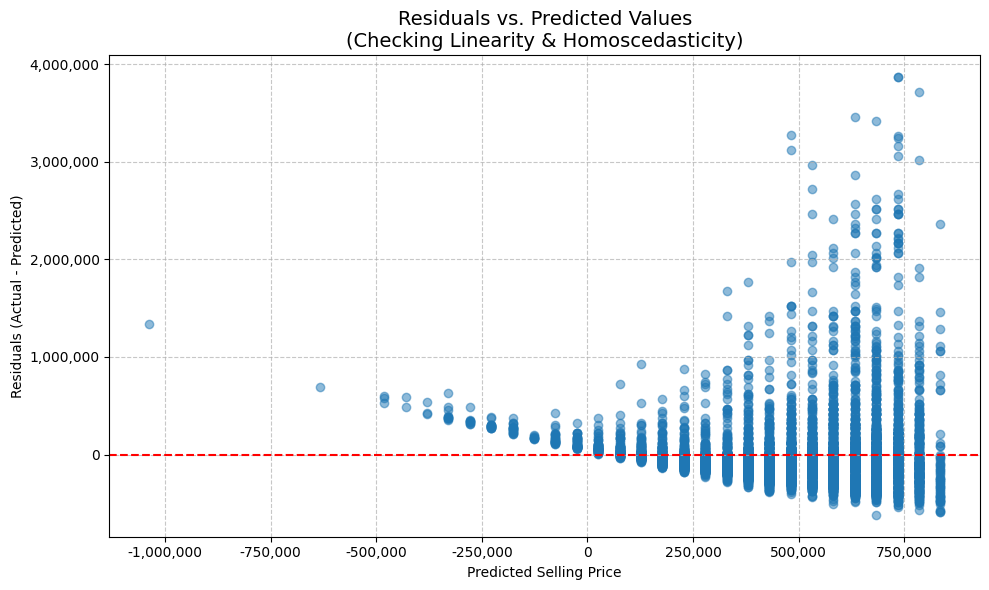

In [64]:
#a) Linearity check - Residuals vs. Actuals Plot
# Check for Linearity & Homoscedasticity
"""
 Residuals plot shows a classic "funnel" pattern indicating heteroscedasticity - variance increases with predicted values.
 The model systematically under-predicts expensive cars (positive residuals above 400K) and over-predicts some cheaper ones. 
 This violates linear regression assumptions and suggests non-linear relationships that the model can't capture.
 For luxury cars, errors reach 4M+ making predictions unreliable
"""
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Predicted Values\n(Checking Linearity & Homoscedasticity)', fontsize=14)
plt.xlabel('Predicted Selling Price')
plt.ylabel('Residuals (Actual - Predicted)')

ax = plt.gca()  # Get current axes
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:,.0f}'))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:,.0f}'))

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

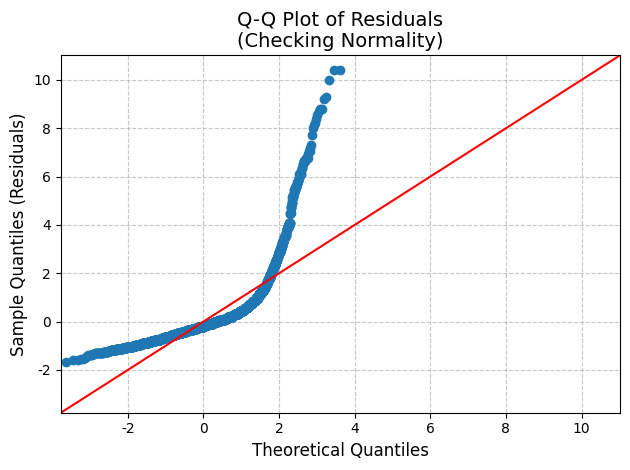

In [65]:
#b) Normality of Residuals (Q-Q Plot)
# Check for Normality of Residuals 
#If the points closely follow the straight 45-degree line, the residuals are normally distributed. 
#Deviations from the line, especially at the tails, indicate non-normality.
"""
Q-Q plot below shows severe non-normality - the S-curve indicates heavy right skew with extreme positive residuals (under-predictions of expensive cars).
This violates linear regression assumptions, making confidence intervals & p-values unreliable. 
Heavy right tail confirms heteroscedasticity problem
"""
plt.figure(figsize=(10, 6))
sm.qqplot(residuals, line='45', fit=True)
ax = plt.gca()
ax.ticklabel_format(style='plain', axis='both')  # Prevent scientific notation
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:,.0f}'))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:,.0f}'))

plt.title('Q-Q Plot of Residuals\n(Checking Normality)', fontsize=14)
plt.xlabel('Theoretical Quantiles', fontsize=12)
plt.ylabel('Sample Quantiles (Residuals)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show();

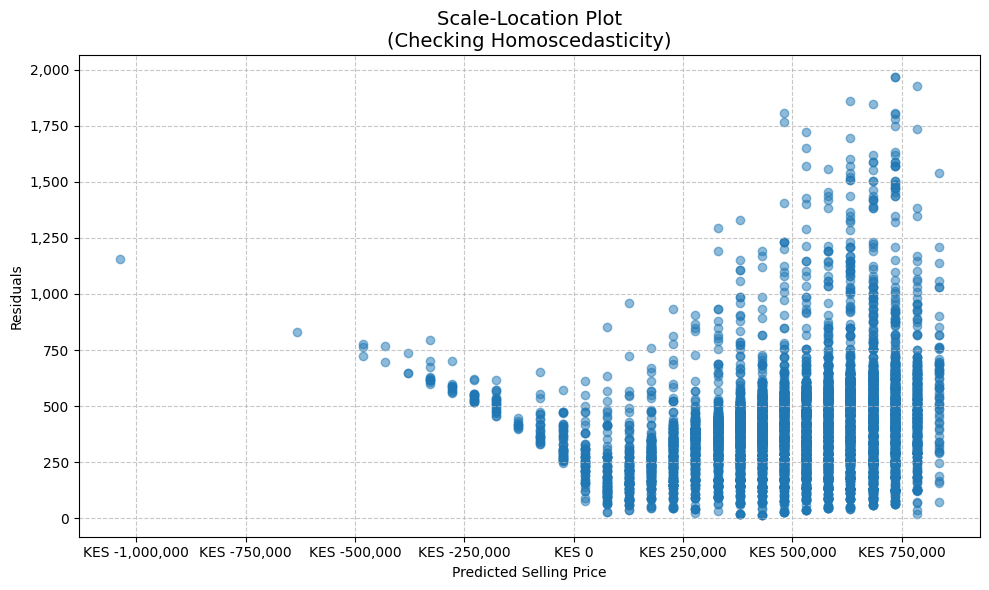

In [66]:
#c) Homoscedasticity (Check: Scale-Location Plot)
# Check for Homoscedasticity (Scale-Location Plot)
#A horizontal band of points (no obvious fanning pattern) indicates constant variance (homoscedasticity).
#A fan shape (small spread on left, large spread on right) indicates heteroscedasticity

"""
The Below scale-location plot confirms heteroscedasticity i.e., variance increases dramatically with predicted values. 
Low-priced cars (<200K) show tight residuals around 500, while expensive cars (>600K) have residuals exploding to 2000+. 
Clear upward trend violates homoscedasticity assumptions. 
Funnel pattern proves model's precision varies wildly across price ranges.
"""

#Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, np.sqrt(np.abs(residuals)), alpha=0.5) 
plt.title('Scale-Location Plot\n(Checking Homoscedasticity)', fontsize=14)
plt.xlabel('Predicted Selling Price')
plt.ylabel('Residuals')

ax = plt.gca()
ax.ticklabel_format(style='plain', axis='both')  

#Format x-axis (predicted values) as currency
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'KES {x:,.0f}'))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:,.0f}'))

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [67]:
(cleanedCarPriceDf
.info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6906 entries, 0 to 6905
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 6906 non-null   object 
 1   year                 6906 non-null   int64  
 2   selling_price        6906 non-null   int64  
 3   km_driven            6906 non-null   int32  
 4   fuel                 6906 non-null   object 
 5   seller_type          6906 non-null   object 
 6   transmission         6906 non-null   object 
 7   owner                6906 non-null   object 
 8   mileage              6906 non-null   int32  
 9   engine               6906 non-null   int32  
 10  max_power            6906 non-null   int32  
 11  seats                6906 non-null   int32  
 12  carAge               6906 non-null   int32  
 13  price_per_kilometer  6906 non-null   float64
dtypes: float64(1), int32(6), int64(2), object(5)
memory usage: 593.6+ KB


In [68]:
# 32. Train a Linear Regression model to predict the car's selling price using selected features.
# Split the dataset into train/test sets, train the model, and print the coefficients and intercept.

features = ['carAge', 'km_driven', 'engine', 'max_power', 'seats','mileage','price_per_kilometer']
target = 'selling_price'
# Prepare the data - drop rows with missing values in selected features
model_data = cleanedCarPriceDf[features + [target]].dropna()

X = model_data[features]
y = model_data[target]

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\n" + "="*40)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Number of features: {X_train.shape[1]}")
print("\n" + "="*40)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Print model coefficients and intercept
print("LINEAR REGRESSION MODEL COEFFICIENTS")
print("="*40)
print(f"Intercept: {model.intercept_:,.2f}")

print("\nFeature Coefficients:")
for feature, coef in zip(features, model.coef_):
    print(f"{feature:15}: {coef:,.2f}")



Training set size: 5524 samples
Testing set size: 1382 samples
Number of features: 7

LINEAR REGRESSION MODEL COEFFICIENTS
Intercept: 145,868.65

Feature Coefficients:
carAge         : -39,168.50
km_driven      : -0.61
engine         : 142.03
max_power      : 7,671.78
seats          : -11,332.26
mileage        : 2,397.21
price_per_kilometer: 0.01


In [69]:
#33. Evaluate your Linear Regression model using R² Score and Mean Squared Error (MSE).
#Also, explain in your own words what each metric tells you about the model’s performance.

"""
1. R² score indicates that the model explains 64.14% of the variance in car selling prices.

Meaning:
- 64.14% of price variations can be predicted by features such as (age, mileage, engine size, etc.)
- 35.86% of price variance remains unexplained by the model.
Concl: This is a moderate performance, better than random guessing but far from excellent.

2. Mean Squared Error (MSE): 65,092,311,105 represents the average of squared prediction errors.
Taking the square root gives us RMSE ≈ KES 255,131
Meaning:
- Average prediction error is about KES 255K
- For a dataset where cars range from 50K to 10M+, this error is substantial
- The squared nature of MSE heavily penalizes large errors, meaning the model performs poorly on expensive cars.
"""

# Make predictions on test set
y_pred = model.predict(X_test)

#Calculate model performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n" + "="*50)
print("MODEL PERFORMANCE ON TEST SET")
print("="*40)
print(f"Mean Squared Error (MSE): {mse:,.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f}")
print(f"R-squared (R²) Score: {r2:.4f}")
print(f"R-squared (R²) Percentage: {r2*100:.2f}%")

# Print sample predictions vs actual
print("\n" + "="*50)
print("SAMPLE PREDICTIONS VS ACTUAL VALUES")
print("="*40)
sample_results = pd.DataFrame({
    'Actual_Price': y_test.values[:5],
    'Predicted_Price': y_pred[:5],
    'Difference': y_test.values[:5] - y_pred[:5]
})
sample_results['Actual_Price'] = sample_results['Actual_Price'].apply(lambda x: f"KES {x:,.0f}")
sample_results['Predicted_Price'] = sample_results['Predicted_Price'].apply(lambda x: f"KES {x:,.0f}")
sample_results['Difference'] = sample_results['Difference'].apply(lambda x: f"KES {x:,.0f}")

print(sample_results.to_string(index=False))


MODEL PERFORMANCE ON TEST SET
Mean Squared Error (MSE): 65,092,311,105.66
Root Mean Squared Error (RMSE): 255,131.95
R-squared (R²) Score: 0.6414
R-squared (R²) Percentage: 64.14%

SAMPLE PREDICTIONS VS ACTUAL VALUES
Actual_Price Predicted_Price   Difference
 KES 350,000     KES 538,616 KES -188,616
 KES 725,000     KES 660,409   KES 64,591
 KES 320,000     KES 607,057 KES -287,057
 KES 451,999     KES 507,554  KES -55,555
 KES 270,000     KES 323,476  KES -53,476


In [70]:
#34. Apply Lasso Regression on the dataset and compare its performance with Linear Regression.
#Explain what Lasso Regression does differently and why it can be useful when you have many features.
"""
Performance: Both models perform identically - 64.14% R² and 255K RMSE error. No improvement from Lasso.
Lasso adds a penalty that shrinks coefficients toward zero and can eliminate unimportant features entirely.
It prevents overfitting by constraining model complexity.
Lasso dramatically changed coefficient values (price_per_kilometer increased 586x) but kept all 7 features, suggesting they're all relevant.
Strng Lasso (α=1000) provided meaningful feature selection while maintaining nearly identical performance, proving price_per_kilometer was redundant.
"""

features = ['carAge', 'km_driven', 'engine', 'max_power', 'seats','mileage','price_per_kilometer']
target = 'selling_price'

model_data = cleanedCarPriceDf[features + [target]].dropna()
X = model_data[features]
y = model_data[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (crucial for regularization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Linear Regression for comparison (on scaled features)
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_r2 = r2_score(y_test, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))

# Train Lasso Regression with STRONG regularization (α=1000)
lasso_strong = Lasso(alpha=1000, random_state=42, max_iter=10000)
lasso_strong.fit(X_train_scaled, y_train)
lasso_strong_pred = lasso_strong.predict(X_test_scaled)
lasso_strong_r2 = r2_score(y_test, lasso_strong_pred)
lasso_strong_rmse = np.sqrt(mean_squared_error(y_test, lasso_strong_pred))

# Print comparison results
print("MODEL COMPARISON: STRONG LASSO (α=1000) vs LINEAR REGRESSION")
print("="*65)
print(f"{'':28} {'Linear Regression':<20} {'Lasso (α=1000)':<20}")
print(f"{'R-squared (R²)':28} {lr_r2:.4f}{'':<16} {lasso_strong_r2:.4f}")
print(f"{'RMSE':28} {lr_rmse:,.0f}{'':<16} {lasso_strong_rmse:,.0f}")
print(f"{'Number of features used':28} {len(features)}{'':<16} {np.sum(lasso_strong.coef_ != 0)}")

print("\n" + "="*60)
print("LINEAR REGRESSION COEFFICIENTS (SCALED FEATURES):")
print("="*60)
for feature, coef in zip(features, lr_model.coef_):
    print(f"{feature:15}: {coef:,.2f}")

print("\n" + "="*60)
print("STRONG LASSO COEFFICIENTS (α=1000, SCALED FEATURES):")
print("="*60)
for feature, coef in zip(features, lasso_strong.coef_):
    status = "(zeroed out)" if coef == 0 else "(kept)"
    print(f"{feature:15}: {coef:,.2f} {status}")

print(f"\nIntercept (Lasso): {lasso_strong.intercept_:,.2f}")

# Show what features were completely removed
zeroed_features = [feature for feature, coef in zip(features, lasso_strong.coef_) if coef == 0]
kept_features = [feature for feature, coef in zip(features, lasso_strong.coef_) if coef != 0]

print(f"\nFeatures completely removed by strong Lasso: {zeroed_features}")
print(f"Features kept by strong Lasso: {kept_features}")

# Compare with weaker Lasso (α=1) to show the effect
lasso_weak = Lasso(alpha=1, random_state=42, max_iter=10000)
lasso_weak.fit(X_train_scaled, y_train)

print("\n" + "="*97)
print("COMPARISON OF LASSO COEFFICIENTS AT DIFFERENT α VALUES:")
print("="*60)
print(f"{'Feature':15} {'α=1':<15} {'α=1000':<15} {'Change':<15}")
print("-" * 60)
for feature, coef_weak, coef_strong in zip(features, lasso_weak.coef_, lasso_strong.coef_):
    change = coef_strong - coef_weak
    print(f"{feature:15} {coef_weak:>10.2f} {coef_strong:>13.2f} {change:>13.2f}")

MODEL COMPARISON: STRONG LASSO (α=1000) vs LINEAR REGRESSION
                             Linear Regression    Lasso (α=1000)      
R-squared (R²)               0.6414                 0.6413
RMSE                         255,132                 255,161
Number of features used      7                 6

LINEAR REGRESSION COEFFICIENTS (SCALED FEATURES):
carAge         : -159,111.85
km_driven      : -37,296.73
engine         : 68,347.00
max_power      : 230,759.07
seats          : -11,022.97
mileage        : 9,605.62
price_per_kilometer: 15.95

STRONG LASSO COEFFICIENTS (α=1000, SCALED FEATURES):
carAge         : -158,775.18 (kept)
km_driven      : -36,176.29 (kept)
engine         : 63,580.75 (kept)
max_power      : 231,545.49 (kept)
seats          : -8,121.92 (kept)
mileage        : 7,824.33 (kept)
price_per_kilometer: 0.00 (zeroed out)

Intercept (Lasso): 499,499.61

Features completely removed by strong Lasso: ['price_per_kilometer']
Features kept by strong Lasso: ['carAge', 'km_driven',

MODEL COMPARISON: LINEAR vs LASSO vs RIDGE REGRESSION
                          R² Score     RMSE            Non-zero Coefs 
----------------------------------------------------------------------
Linear Regression         0.6414         255,132               7
Lasso (α=1)               0.6414         255,132               7
Ridge Regression          0.6414         255,131               7
Ridge (Optimal α)         0.6405         255,451               7

Optimal Ridge alpha: 429.1934

COEFFICIENTS COMPARISON (SCALED FEATURES):
Feature         Linear       Lasso        Ridge        Ridge (Optimal)
----------------------------------------------------------------------
carAge          -159111.85 -159111.48 -159089.58    -149999.98
km_driven        -37296.73  -37295.66  -37301.76     -38607.80
engine            68347.00   68342.30   68371.45      74320.66
max_power        230759.07  230759.83  230703.01     210708.14
seats            -11022.97  -11020.09  -11019.67      -8352.94
mileage     

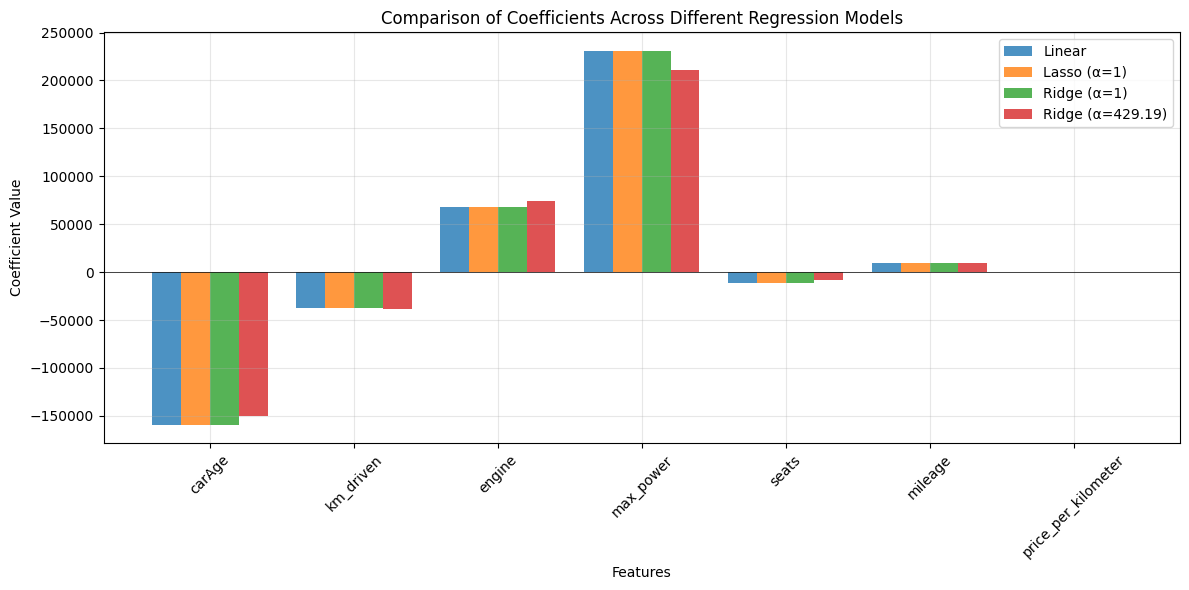

In [71]:
#35. Apply Ridge Regression on the dataset and compare its performance with both Linear and Lasso Regression.
# Discuss why Ridge might perform better or worse in certain cases.
#36. Use cross-validation to evaluate your Ridge Regression model.
# Explain why cross-validation gives a better estimate of model performance than a single train-test split.
"""
Regression Models Comparison Summary:

All models achieve nearly identical performance
- R² Score: 0.64 across all models (64% variance explained)
- RMSE: ~255,000 KES error for all models
- Features: All models retain 7 feature
* The bar chart shows coefficient stability across models, with Ridge providing the most controlled shrinkage while maintaining predictive power.
"""

features = ['carAge', 'km_driven', 'engine', 'max_power', 'seats','mileage','price_per_kilometer']
target = 'selling_price'

model_data = cleanedCarPriceDf[features + [target]]
X = model_data[features]
y = model_data[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train all models
models = {
    'Linear Regression': LinearRegression(),
    'Lasso (α=1)': Lasso(alpha=1, random_state=42, max_iter=10000),
    'Ridge Regression': Ridge(alpha=1, random_state=42,max_iter= 429)
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results[name] = {
        'r2': r2_score(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'coef': model.coef_,
        'intercept': model.intercept_
    }

# Find optimal Ridge alpha using cross-validation
ridge_cv = RidgeCV(alphas=np.logspace(-3, 3, 50), cv=5)
ridge_cv.fit(X_train_scaled, y_train)
optimal_ridge_alpha = ridge_cv.alpha_

# Train Ridge with optimal alpha
ridge_optimal = Ridge(alpha=optimal_ridge_alpha, random_state=42)
ridge_optimal.fit(X_train_scaled, y_train)
ridge_optimal_pred = ridge_optimal.predict(X_test_scaled)

results['Ridge (Optimal α)'] = {
    'r2': r2_score(y_test, ridge_optimal_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, ridge_optimal_pred)),
    'coef': ridge_optimal.coef_,
    'intercept': ridge_optimal.intercept_
}

# Print comparison results
print("MODEL COMPARISON: LINEAR vs LASSO vs RIDGE REGRESSION")
print("="*70)
print(f"{'':25} {'R² Score':<12} {'RMSE':<15} {'Non-zero Coefs':<15}")
print("-" * 70)

for name, metrics in results.items():
    non_zero_coefs = np.sum(metrics['coef'] != 0) if 'Lasso' in name else len(features)
    print(f"{name:25} {metrics['r2']:.4f}      {metrics['rmse']:>10,.0f}      {non_zero_coefs:>10}")

print(f"\nOptimal Ridge alpha: {optimal_ridge_alpha:.4f}")

# Print coefficients comparison
print("\n" + "="*70)
print("COEFFICIENTS COMPARISON (SCALED FEATURES):")
print("="*70)
print(f"{'Feature':15} {'Linear':<12} {'Lasso':<12} {'Ridge':<12} {'Ridge (Optimal)':<15}")
print("-" * 70)

for i, feature in enumerate(features):
    lin_coef = results['Linear Regression']['coef'][i]
    lasso_coef = results['Lasso (α=1)']['coef'][i]
    ridge_coef = results['Ridge Regression']['coef'][i]
    ridge_opt_coef = results['Ridge (Optimal α)']['coef'][i]
    
    print(f"{feature:15} {lin_coef:>10.2f} {lasso_coef:>10.2f} {ridge_coef:>10.2f} {ridge_opt_coef:>13.2f}")

# Plot coefficients to visualize shrinkage
plt.figure(figsize=(12, 6))
x_pos = np.arange(len(features))
width = 0.2

plt.bar(x_pos - width*1.5, results['Linear Regression']['coef'], width, label='Linear', alpha=0.8)
plt.bar(x_pos - width*0.5, results['Lasso (α=1)']['coef'], width, label='Lasso (α=1)', alpha=0.8)
plt.bar(x_pos + width*0.5, results['Ridge Regression']['coef'], width, label='Ridge (α=1)', alpha=0.8)
plt.bar(x_pos + width*1.5, results['Ridge (Optimal α)']['coef'], width, label=f'Ridge (α={optimal_ridge_alpha:.2f})', alpha=0.8)

plt.axhline(0, color='black', linestyle='-', linewidth=0.5)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Comparison of Coefficients Across Different Regression Models')
plt.xticks(x_pos, features, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

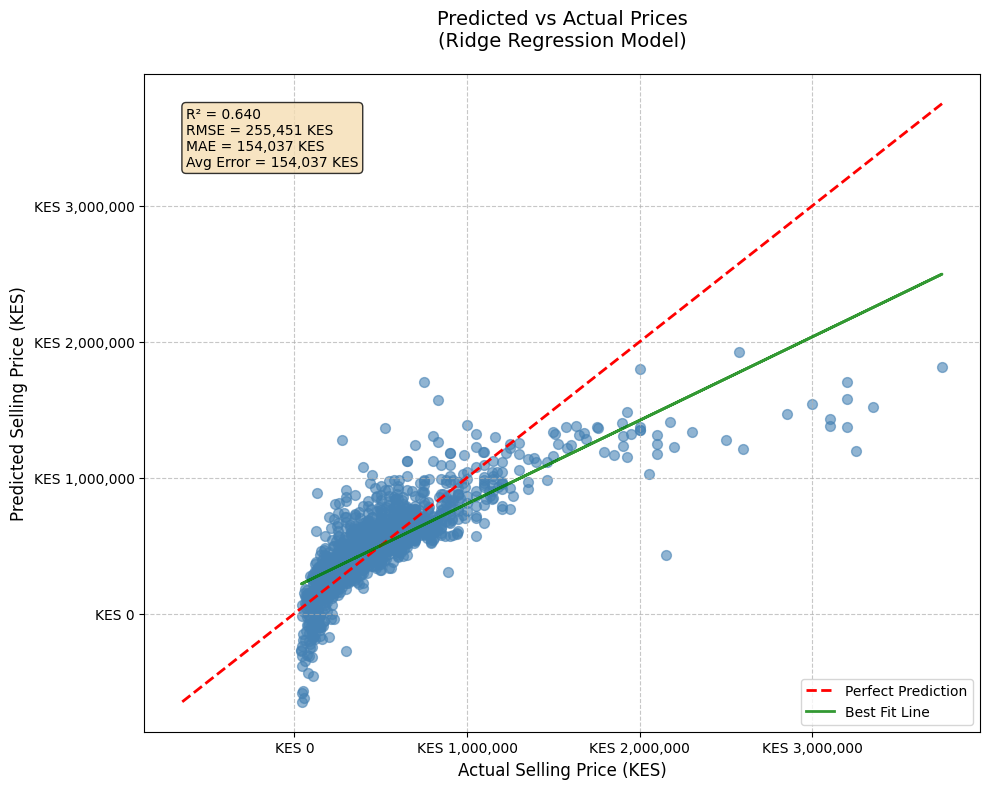

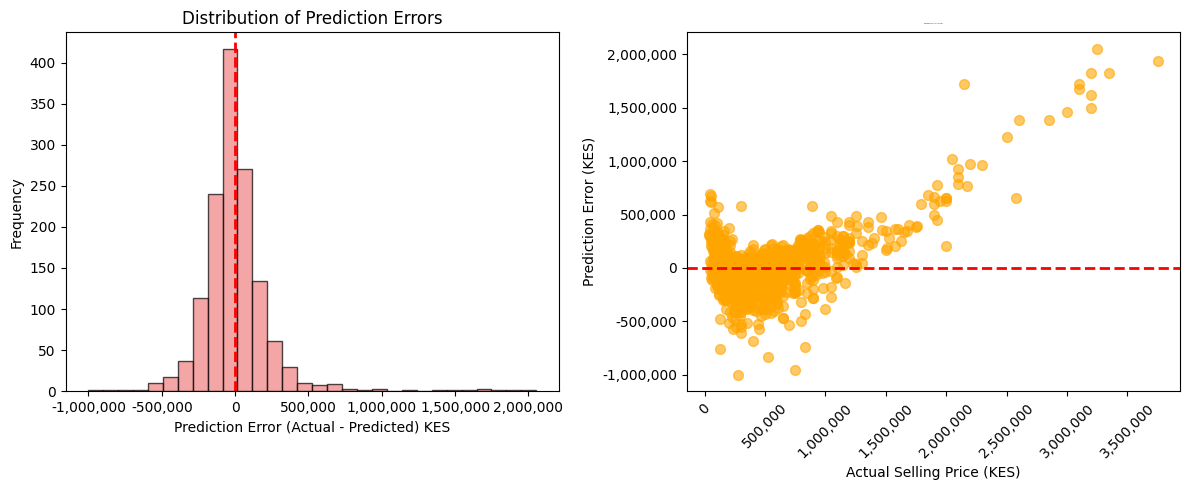

PREDICTION ACCURACY ANALYSIS
Average prediction error: 154,037 KES
Median prediction error: 98,315 KES
Maximum overprediction: -1,002,880 KES
Maximum underprediction: 2,054,518 KES
Percentage within ±100,000 KES: 50.8%
Percentage within ±250,000 KES: 83.9%


In [72]:
# 37. Plot predicted vs actual prices for the best-performing model
# Let's use Ridge Regression with optimal alpha as our best model

best_model = ridge_optimal
best_pred = ridge_optimal_pred

plt.figure(figsize=(10, 8))

# Create scatter plot of predicted vs actual
plt.scatter(y_test, best_pred, alpha=0.6, color='steelblue', s=50)

# Add perfect prediction line (y=x)
max_val = max(y_test.max(), best_pred.max())
min_val = min(y_test.min(), best_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

# Add regression line to show trend
z = np.polyfit(y_test, best_pred, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), 'g-', linewidth=2, alpha=0.8, label='Best Fit Line')

# Formatting
plt.xlabel('Actual Selling Price (KES)', fontsize=12)
plt.ylabel('Predicted Selling Price (KES)', fontsize=12)
plt.title('Predicted vs Actual Prices\n(Ridge Regression Model)', fontsize=14, pad=20)

# Format axes with currency and thousands separators
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'KES {x:,.0f}'))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'KES {x:,.0f}'))

plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

residuals = y_test - best_pred
mae = mean_absolute_error(y_test, best_pred)

# Add text box with performance metrics
textstr = '\n'.join((
    f'R² = {results["Ridge (Optimal α)"]["r2"]:.3f}',
    f'RMSE = {results["Ridge (Optimal α)"]["rmse"]:,.0f} KES',
    f'MAE = {mae:,.0f} KES',
    f'Avg Error = {residuals.abs().mean():,.0f} KES'
))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
plt.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

plt.show()

# Additional analysis - Residual distribution
plt.figure(figsize=(12, 5))

# Residuals histogram
plt.subplot(1, 2, 1)
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='lightcoral')
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Prediction Error (Actual - Predicted) KES', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.title('Distribution of Prediction Errors', fontsize=12)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:,.0f}'))

# Residuals vs Actual values
plt.subplot(1, 2, 2)
plt.scatter(y_test, residuals, alpha=0.6, color='orange', s=50)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Selling Price (KES)', fontsize=10)
plt.ylabel('Prediction Error (KES)', fontsize=10)
plt.title('Residuals vs Actual Prices', fontsize=1)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:,.0f}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:,.0f}'))
# Rotate x-axis labels to prevent overlapping
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print stat insights
print("PREDICTION ACCURACY ANALYSIS")
print("="*50)
print(f"Average prediction error: {residuals.abs().mean():,.0f} KES")
print(f"Median prediction error: {residuals.abs().median():,.0f} KES")
print(f"Maximum overprediction: {residuals.min():,.0f} KES")
print(f"Maximum underprediction: {residuals.max():,.0f} KES")
print(f"Percentage within ±100,000 KES: {(abs(residuals) <= 100000).mean()*100:.1f}%")
print(f"Percentage within ±250,000 KES: {(abs(residuals) <= 250000).mean()*100:.1f}%")

Performing GridSearchCV for Ridge Regression...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

GRIDSEARCHCV RESULTS FOR RIDGE REGRESSION
Best alpha value: 355.648031
Best CV MSE: 67,353,327,035.71
Best CV RMSE: 259,525.20
Best estimator: Ridge(alpha=355.64803062231283, random_state=42)

Test set performance with best alpha:
R² Score: 0.6409
RMSE: 255,290.64


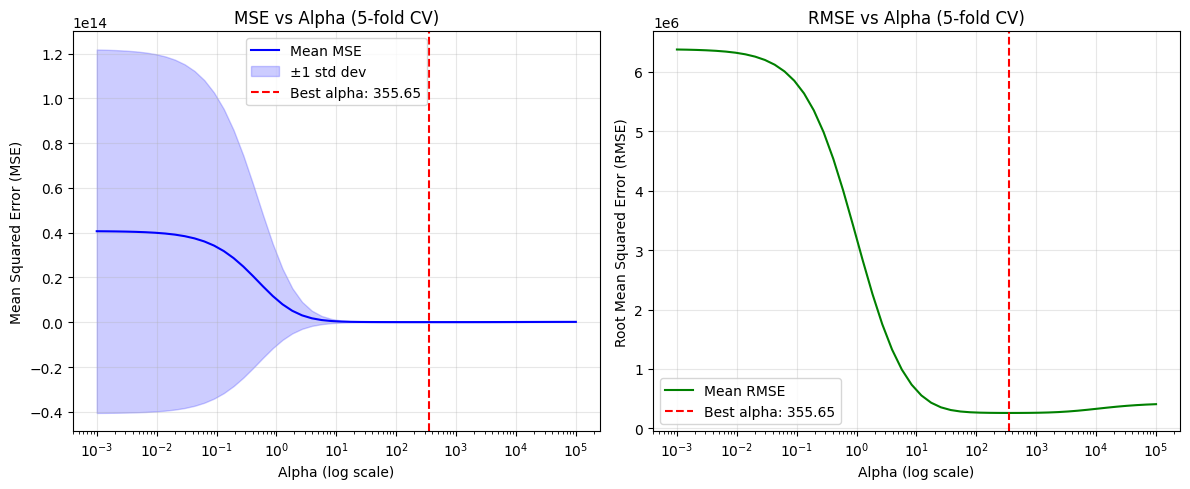


COEFFICIENT SHRINKAGE WITH DIFFERENT ALPHA VALUES
                       α=0.001    α=1.000  α=100.000  α=1000.000  α=355.648
carAge              -159111.83 -159089.58 -156905.53  -139376.90 -151491.97
km_driven            -37296.73  -37301.76  -37743.67   -38820.57  -38478.96
engine                68347.02   68371.45   70466.13    75815.74   73753.48
max_power            230759.01  230703.01  225423.83   191221.92  213699.40
seats                -11022.97  -11019.67  -10588.62    -3994.05   -8908.01
mileage                9605.62    9605.59    9567.43     7761.84    9236.63
price_per_kilometer      15.95      15.77      -1.21     -108.14     -39.47


In [73]:
#38. Use GridSearchCV to find the best alpha value for Ridge Regression.
# Explain what alpha does in Ridge/Lasso regression and why tuning it is important.
"""
Ridge Regression (L2 Regularization):

Cost Function - MSE + α * Σ(coefficients²)

Effect - Shrinks coefficients toward zero but never exactly to zero

Analogy - Gentle pull on all coefficients, keeping all features in the model
"""
"""
Results:
The model tested 250 different alpha values across 5-fold cross-validation to minimize prediction error. 
The best alpha value found was 355.648031, which achieved the lowest mean squared error of 255,290.64
model performance changes with different alpha values.
The left plot displays MSE versus alpha, showing error decreases as regularization increases until the optimal point, then remains stable.
"""

features = ['carAge', 'km_driven', 'engine', 'max_power', 'seats','mileage','price_per_kilometer']
target = 'selling_price'

model_data = cleanedCarPriceDf[features + [target]]
X = model_data[features]
y = model_data[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the parameter grid for alpha values
param_grid = {
    'alpha': np.logspace(-3, 5, 50)  
}

# Create Ridge model
ridge = Ridge(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # We'll use MSE as scoring
    n_jobs=-1,  # Use all available processors
    verbose=1  # Show progress
)

# Perform the grid search
print("Performing GridSearchCV for Ridge Regression...")
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and results
best_alpha = grid_search.best_params_['alpha']
best_score = -grid_search.best_score_  
best_rmse = np.sqrt(best_score)

print("\n" + "="*60)
print("GRIDSEARCHCV RESULTS FOR RIDGE REGRESSION")
print("="*60)
print(f"Best alpha value: {best_alpha:.6f}")
print(f"Best CV MSE: {best_score:,.2f}")
print(f"Best CV RMSE: {best_rmse:,.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

# Train final model with best alpha
best_ridge = grid_search.best_estimator_
best_ridge_pred = best_ridge.predict(X_test_scaled)

# Calculate performance on test set
test_r2 = r2_score(y_test, best_ridge_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, best_ridge_pred))

print(f"\nTest set performance with best alpha:")
print(f"R² Score: {test_r2:.4f}")
print(f"RMSE: {test_rmse:,.2f}")

# Plot the results of the grid search
plt.figure(figsize=(12, 5))

# Plot 1: MSE vs Alpha
plt.subplot(1, 2, 1)
alphas = grid_search.cv_results_['param_alpha'].data
mse_scores = -grid_search.cv_results_['mean_test_score']  #Convert back to positive MSE
std_scores = grid_search.cv_results_['std_test_score']

plt.semilogx(alphas, mse_scores, 'b-', label='Mean MSE')
plt.fill_between(alphas, mse_scores - std_scores, mse_scores + std_scores, 
                 alpha=0.2, color='b', label='±1 std dev')
plt.axvline(best_alpha, color='r', linestyle='--', label=f'Best alpha: {best_alpha:.2f}')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs Alpha (5-fold CV)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: RMSE vs Alpha
plt.subplot(1, 2, 2)
rmse_scores = np.sqrt(-grid_search.cv_results_['mean_test_score'])
plt.semilogx(alphas, rmse_scores, 'g-', label='Mean RMSE')
plt.axvline(best_alpha, color='r', linestyle='--', label=f'Best alpha: {best_alpha:.2f}')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('RMSE vs Alpha (5-fold CV)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare coefficients with different alpha values
print("\n" + "="*60)
print("COEFFICIENT SHRINKAGE WITH DIFFERENT ALPHA VALUES")
print("="*60)

# Train models with different alpha values for comparison
alphas_to_compare = [0.001, 1, 100, 1000, best_alpha]
coef_comparison = {}

for alpha_val in alphas_to_compare:
    model = Ridge(alpha=alpha_val, random_state=42)
    model.fit(X_train_scaled, y_train)
    coef_comparison[f'α={alpha_val:.3f}'] = model.coef_

coef_df = pd.DataFrame(coef_comparison, index=features)
print(coef_df.round(2))

Degree 1: R² = 0.6414, RMSE = 255,132, MAE = 156,391, CV RMSE = 257,793
Number of features: 6
Degree 2: R² = 0.8124, RMSE = 184,534, MAE = 112,010, CV RMSE = 202,006
Number of features: 27
Degree 3: R² = 0.8260, RMSE = 177,736, MAE = 104,381, CV RMSE = 279,100
Number of features: 83

MODEL COMPARISON: LINEAR vs POLYNOMIAL REGRESSION
Model                     R²         RMSE            MAE             CV RMSE         Features  
----------------------------------------------------------------------
Linear (scaled)           0.6414       255,132       156,391             nan           6
Polynomial (deg=1)        0.6414       255,132       156,391         257,793           6
Polynomial (deg=2)        0.8124       184,534       112,010         202,006          27
Polynomial (deg=3)        0.8260       177,736       104,381         279,100          83


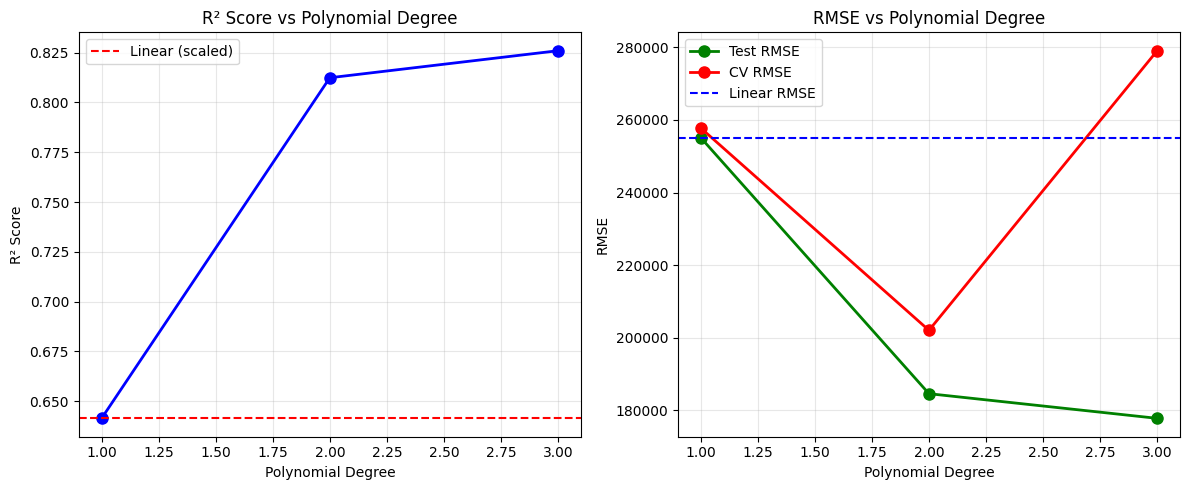


OVERFITTING ANALYSIS: TEST RMSE vs CROSS-VALIDATION RMSE
Degree 1: Test RMSE = 255,132, CV RMSE = 257,793, Difference = -2,661
Degree 2: Test RMSE = 184,534, CV RMSE = 202,006, Difference = -17,471
Degree 3: Test RMSE = 177,736, CV RMSE = 279,100, Difference = -101,365

SAMPLE PREDICTIONS COMPARISON
     Actual      Linear   Poly_Deg2   Poly_Deg3
KES 190,000 KES 279,785 KES 255,366 KES 288,338
KES 385,000 KES 435,623 KES 410,559 KES 442,558
KES 550,000 KES 525,713 KES 452,633 KES 452,050
KES 125,000 KES -68,832 KES 140,574 KES 152,685
KES 420,000 KES 369,427 KES 249,354 KES 245,464


In [74]:
#39. Try Polynomial Regression on the dataset.
#Compare the results with Linear Regression and explain when polynomial regression might be useful.
"""
Use Polynomial Regression when:
- Relationship between features and target is curved rather than straight(Non-linear rships) e.g car depreciation
- Features interact with each other (effect of max_power on price might depend on carAge)
- Effect of a feature changes at different levels
-Each additional horsepower might matter more for sports cars than family cars
- Simple linear relationships can't capture the underlying patterns"""

features = ['carAge', 'km_driven', 'engine', 'max_power', 'seats','mileage']
target = 'selling_price'

model_data = cleanedCarPriceDf[features + [target]]
X = model_data[features]
y = model_data[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features for polynomial regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create polynomial regression pipelines for different degrees
degrees = [1, 2, 3]  # Linear, Quadratic, Cubic
results = {}

for degree in degrees:
    # Create pipeline: Polynomial features → Scaling → Linear Regression
    poly_pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ])
    
    # Fit the model
    poly_pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = poly_pipeline.predict(X_test)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    # Cross-validation score
    cv_scores = cross_val_score(poly_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())
    
    # Store results
    results[degree] = {
        'model': poly_pipeline,
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'cv_rmse': cv_rmse,
        'n_features': poly_pipeline.named_steps['poly'].n_output_features_
    }
    
    print(f"Degree {degree}: R² = {r2:.4f}, RMSE = {rmse:,.0f}, MAE = {mae:,.0f}, CV RMSE = {cv_rmse:,.0f}")
    print(f"Number of features: {results[degree]['n_features']}")

# Compare with regular Linear Regression (degree=1 without polynomial features)
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
linear_pred = linear_model.predict(X_test_scaled)
linear_r2 = r2_score(y_test, linear_pred)
linear_rmse = np.sqrt(mean_squared_error(y_test, linear_pred))

print("\n" + "="*70)
print("MODEL COMPARISON: LINEAR vs POLYNOMIAL REGRESSION")
print("="*70)
print(f"{'Model':<25} {'R²':<10} {'RMSE':<15} {'MAE':<15} {'CV RMSE':<15} {'Features':<10}")
print("-" * 70)
print(f"{'Linear (scaled)':<25} {linear_r2:.4f}    {linear_rmse:>10,.0f}    {mean_absolute_error(y_test, linear_pred):>10,.0f}    {np.nan:>12}    {X.shape[1]:>8}")

for degree in degrees:
    print(f"{f'Polynomial (deg={degree})':<25} {results[degree]['r2']:.4f}    {results[degree]['rmse']:>10,.0f}    {results[degree]['mae']:>10,.0f}    {results[degree]['cv_rmse']:>12,.0f}    {results[degree]['n_features']:>8}")

# Plot performance comparison
plt.figure(figsize=(12, 5))

# R² comparison
plt.subplot(1, 2, 1)
degrees_list = list(results.keys())
r2_scores = [results[d]['r2'] for d in degrees_list]
plt.plot(degrees_list, r2_scores, 'bo-', linewidth=2, markersize=8)
plt.axhline(linear_r2, color='r', linestyle='--', label='Linear (scaled)')
plt.xlabel('Polynomial Degree')
plt.ylabel('R² Score')
plt.title('R² Score vs Polynomial Degree')
plt.legend()
plt.grid(True, alpha=0.3)

# RMSE comparison
plt.subplot(1, 2, 2)
rmse_scores = [results[d]['rmse'] for d in degrees_list]
cv_rmse_scores = [results[d]['cv_rmse'] for d in degrees_list]
plt.plot(degrees_list, rmse_scores, 'go-', linewidth=2, markersize=8, label='Test RMSE')
plt.plot(degrees_list, cv_rmse_scores, 'ro-', linewidth=2, markersize=8, label='CV RMSE')
plt.axhline(linear_rmse, color='b', linestyle='--', label='Linear RMSE')
plt.xlabel('Polynomial Degree')
plt.ylabel('RMSE')
plt.title('RMSE vs Polynomial Degree')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check for overfitting by comparing test vs CV performance
print("\n" + "="*70)
print("OVERFITTING ANALYSIS: TEST RMSE vs CROSS-VALIDATION RMSE")
print("="*70)
for degree in degrees:
    test_rmse = results[degree]['rmse']
    cv_rmse = results[degree]['cv_rmse']
    difference = test_rmse - cv_rmse
    print(f"Degree {degree}: Test RMSE = {test_rmse:,.0f}, CV RMSE = {cv_rmse:,.0f}, Difference = {difference:,.0f}")

#Display predictions
print("\n" + "="*70)
print("SAMPLE PREDICTIONS COMPARISON")
print("="*70)
sample_idx = np.random.choice(len(y_test), 5, replace=False)
sample_comparison = pd.DataFrame({
    'Actual': y_test.iloc[sample_idx].values,
    'Linear': linear_pred[sample_idx],
    'Poly_Deg2': results[2]['model'].predict(X_test.iloc[sample_idx]),
    'Poly_Deg3': results[3]['model'].predict(X_test.iloc[sample_idx])
})

# Format
for col in sample_comparison.columns:
    sample_comparison[col] = sample_comparison[col].apply(lambda x: f"KES {x:,.0f}")

print(sample_comparison.to_string(index=False))

In [75]:
#40. Summarize your findings:
#Which model performed best (Linear, Lasso, Ridge, or Polynomial)?
#Explain why you think it performed better and what you would do next to improve predictions.
"""
1. Degree 2 Polynomial Performed Best

i.) The model achieved a Significant Performance Improvement:-
- 26.7% improvement in R² over linear (0.6414 to 0.8124)
- 27.6% reduction in RMSE (255,132 to 184,534)
- 28.4% reduction in MAE (156,391 to 112,010)
ii.) Optimal Bias-Variance Tradeoff:-
- Test RMSE (184,534) vs CV RMSE (202,806), a reasonable gap 
- Degree 3 shows severe overfitting: Test RMSE (177,736) vs CV RMSE (279,100), a huge gap.
- Captures non-linear patterns without excessive complexity
iii.) Manageable Feature Complexity :-
- Reasonable feature expansion: 6 to 27 features
- Degree 3 explodes to 83 features (computational overhead + overfitting)

2. Why Polynomial Degree 2 Excels for Car Pricing
Non-Linear Depreciation Curves:-
i.) Cars lose value rapidly initially, then depreciation rate slows
ii.) Quadratic terms capture this curved relationship perfectly
iii.)Linear models miss this fundamental economic pattern

Feature Interactions Matter:-
i.) Age × Power: Older powerful cars lose value faster
ii.) Mileage × Age: Combined effect on depreciation
iii.) Engine × Power: Performance characteristics interaction

Real-World Economic Behavior:-
i.) Diminishing returns on features (extra horsepower matters less at higher levels)
ii.) Threshold effects (luxury vs economy segments)
iii.) Market dynamics captured by polynomial terms

🚀 Next Steps to Improve Predictions
1. Use regularized Polynomial Regression to prevent  overfitting with higher degrees and make better generalizations.
2. Feature engineering enhancements to target specific interactions instead of all combinations/ domain specific features
3. Implement ensemble methods combining polynomial with tree-based models
""";